# Extracting log mel spectrogram
오디오 데이터에서 log mel spectrogram을 추출합니다.

In [1]:
import librosa
import librosa.display
import os
import numpy as np
from tqdm import tqdm
import noisereduce as nr
import pathlib
import matplotlib.pyplot as plt
import datetime

In [2]:
# normalization
def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

In [3]:
def get_spectrograms(path, file, category):
    
    # load audio file
    y, sr = librosa.load(os.path.join(path, file), sr=16000)

    # extract log mel spectrogram
    ps = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=512, hop_length=256, win_length=512)
    ps_db = librosa.power_to_db(ps, ref=np.max)
    if ps_db.shape == (128, 17):
        np.save(r"Spec_features/" + "_" + file + '_'+ category + ".npy", ps_db)


categories = ['OtherSound', 'Speaking']
augs = ['Mixed', 'Reduced', 'sliced']

basic_path = r'../Dataset_audio'

for category in os.listdir(basic_path):
    if category in categories:
        for aug in os.listdir(basic_path + '/' + category):
            if aug in augs:
                for file in os.listdir(basic_path + '/' +category + '/' +aug):
                    if file.endswith('.wav') | file.endswith('.WAV'):
                        get_spectrograms(basic_path + '/' +category + '/' +aug, file, category)

# Model

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from collections import Counter
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

from sklearn.utils import class_weight
from collections import Counter


In [6]:
def get_data(path, sampleSize):
    
    #Category
    OtherSound = 'OtherSound'
    Speaking = 'Speaking'
    
    X = []
    y = []
    
    
    for file in os.listdir(path):
        
        a = (np.load(path + "/" + file)).T
        a = np.nan_to_num(a, copy=False)
        a = np.mean(a, axis=0) # 각 시간별 값의 평균을 냄.
        
        # Normalizing
        a = minMaxNormalize(a)
        a = np.reshape(a, (1, 16, 8))

        label = file.split('_')[-1].split(".")[0]
        if label == OtherSound:
#             print(file, 'It is OtherSound file')
            label="OtherSound"
            X.append(a)
            y.append(label)

        elif label == Speaking:
#             print(file, 'It is Speaking file')
            label="Speaking"
            X.append(a)
            y.append(label)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.nan_to_num(X_train, copy=False)
    y_train = np.nan_to_num(y_train, copy=False)
    X_test = np.nan_to_num(X_test, copy=False)
    y_test = np.nan_to_num(y_test, copy=False)
    
    # delete overlap
    X_train, overlap_index = np.unique(X_train, axis=0, return_index=True)
    y_train = y_train[overlap_index]

    X_test, overlap_index = np.unique(X_test, axis=0, return_index=True)
    y_test = y_test[overlap_index]

    
    return X_train, y_train, X_test, y_test

In [7]:
featuresPath = "/home/bongseok/Desktop/speaking_detector/Spec_features"

X_train, y_train, X_test, y_test = get_data(featuresPath, 250) # 학습데이터 구축, samplesize=250

/home/bongseok/venv3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [8]:
n_samples = len(y_train)
print("Num of training samples: " + str(n_samples))
order = np.array(range(n_samples))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]

lb = LabelEncoder() # inverse_transform: Transform labels back to original encoding
y_train = np_utils.to_categorical(lb.fit_transform(y_train)) # fit_transform: Fit label encoder and return encoded labels
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
num_labels = y_train.shape[1]


#lb.inverse_transform([y_train[0]])[0]

Num of training samples: 237499


In [16]:
n_samples = len(y_train)
print("Num of training samples: " + str(n_samples))
order = np.array(range(n_samples))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]

Num of training samples: 237499


In [17]:
# train set에서 speaking, othersound 의 데이터 개수가 잘 맞는지 확인합니다.
oth_count = 0
spe_count = 0
for i in y_train:
    if i[0] == 0.:
        oth_count +=1
    elif i[0] == 1.:
        spe_count +=1
print(oth_count, spe_count)

42090 45317


In [18]:
oth_count = 0
spe_count = 0
for i in y_test:
    if i[0] == 0.:
        oth_count +=1
    elif i[0] == 1.:
        spe_count +=1
print(oth_count, spe_count)

4714 5128


In [19]:
# Check Nan or Inf
for i in X_train:
    if np.isfinite(i.any()) == False:
        print('false')

In [20]:
for i in X_test:
    if np.isfinite(i.any()) == False:
        print('false')

In [21]:
print(len(X_test[2]))
print(len(X_test[3]))

1
1


In [46]:
# build model
# 128 mel
# 168 X 8로 reshape

# 2D convolutional layer (4 X 2 filter)
# 2 X 2 max-pooling
# 0.2 dropout
# relu

# 2D convolutional layer (4 X 2 filter)
# 2 X 2 max-pooling
# 0.2 dropout
# relu

# flatten

# dense layer(128)
# dense layer(2, softmax, adam)

# rate=0.001, epoch=30
opt = optimizers.Adam(learning_rate=0.0005)

metrics = [#tf.keras.metrics.TruePositives(name='TP'),
           #tf.keras.metrics.FalsePositives(name='FP'),
           #tf.keras.metrics.TrueNegatives(name='TN'),
           #tf.keras.metrics.FalseNegatives(name='FN'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
#tf.keras.metrics.AUC(name='auc')]



model = Sequential()
model.add(Conv2D(128, (4, 2), padding='same',
                 input_shape=(1, 16, 8)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))


model.add(Conv2D(128, (4, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    
model.add(Conv2D(128, (4, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.30))

model.add(Flatten())

model.add(Dense(128, input_shape=(512,)))
model.add(Activation('relu'))

model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=metrics, optimizer=opt)


model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 16, 128)        8320      
_________________________________________________________________
activation_21 (Activation)   (None, 1, 16, 128)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 8, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 8, 128)         131200    
_________________________________________________________________
activation_22 (Activation)   (None, 1, 8, 128)         0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 4, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 4, 128)        

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10) # , patience=5
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


history = model.fit(X_train, y_train, 
                    batch_size=8, 
                    epochs=100,
                    validation_split=0.1, callbacks=[es])
#callbacks=[es, mc]
result = model.predict(X_test)

Epoch 1/100
26719/26719 [==============================] - 70s 3ms/step - precision: 0.8999 - loss: 0.2515 - recall: 0.8999 - accuracy: 0.8999 - val_accuracy: 0.9147 - val_precision: 0.9147 - val_recall: 0.9147 - val_loss: 0.2227
Epoch 2/100
26719/26719 [==============================] - 70s 3ms/step - precision: 0.9248 - loss: 0.1988 - recall: 0.9248 - accuracy: 0.9248 - val_accuracy: 0.9354 - val_precision: 0.9354 - val_recall: 0.9354 - val_loss: 0.1768
Epoch 3/100
26719/26719 [==============================] - 70s 3ms/step - precision: 0.9314 - loss: 0.1828 - recall: 0.9314 - accuracy: 0.9314 - val_accuracy: 0.9360 - val_precision: 0.9360 - val_recall: 0.9360 - val_loss: 0.1704
Epoch 4/100
26719/26719 [==============================] - 70s 3ms/step - precision: 0.9357 - loss: 0.1713 - recall: 0.9357 - accuracy: 0.9357 - val_accuracy: 0.9397 - val_precision: 0.9397 - val_recall: 0.9397 - val_loss: 0.1646
Epoch 5/100
26719/26719 [==============================] - 71s 3ms/step - precis

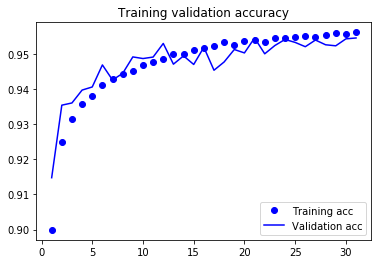

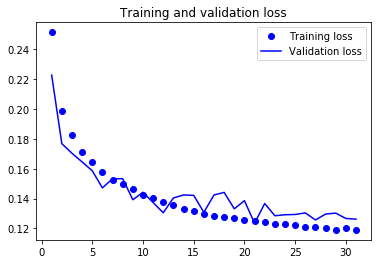

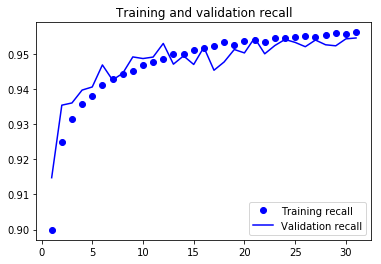

<Figure size 432x288 with 0 Axes>

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']



epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

# plt.plot(epochs, precision, 'bo', label='Training precision')
# plt.plot(epochs, val_precision, 'b', label='Validation precision')
# plt.title('Training and validation precision')
# plt.legend()

# plt.figure()


plt.show()

In [49]:

# 실제값과 예측값을 비교하는 부분입니다.

def print_M(conf_M): 
    s = "activity:"
    for i in range(len(conf_M)):
        s += lb.inverse_transform([i])[0] + ","
    print(s[:-1])
    for i in range(len(conf_M)):
        s = ""
        for j in range(len(conf_M)):
            s += str(conf_M[i][j])
            s += ","
        print(lb.inverse_transform([i])[0], ",", s[:-1])
    print()
    
def print_M_P(conf_M):
    s = "activity:"
    for i in range(len(conf_M)):
        s += lb.inverse_transform([i])[0] + ","
    print(s[:-1])
    for i in range(len(conf_M)):
        s = ""
        for j in range(len(conf_M)):
            val = conf_M[i][j] / float(sum(conf_M[i]))
            s += str(round(val, 2))
            s += ","
        print(lb.inverse_transform([i])[0], ",", s[:-1])
    print()
    
    
def showResult():
    predictions = [np.argmax(y) for y in result]
    expected = [np.argmax(y) for y in y_test]

    conf_M = [] #예측값 개수, 실젯값 개수
    num_labels = y_test[0].shape[0]
    for i in range(num_labels):
        r = []
        for j in range(num_labels):
            r.append(0)
        conf_M.append(r)
    print("initial value of conf_M: ", conf_M)

    n_tests = len(predictions)
    for i in range(n_tests):
        conf_M[expected[i]][predictions[i]] += 1

    print("conf_M: ", conf_M)
    print_M(conf_M)
    print_M_P(conf_M)
    print("label 개수: ", num_labels)

showResult()# 실제값, 예측값
# conf_M의 [0][0]: 실제값과 예측값 모두 0인 횟수
# conf_M의 [1][1]: 실제값과 예측값 모두 1인 횟수

initial value of conf_M:  [[0, 0], [0, 0]]
conf_M:  [[12993, 539], [735, 12367]]
activity:OtherSound,Speaking
OtherSound , 12993,539
Speaking , 735,12367

activity:OtherSound,Speaking
OtherSound , 0.96,0.04
Speaking , 0.06,0.94

label 개수:  2


In [52]:
cnt = 0

for i in range(len(y_test)):
    if(np.amax(result[i])<0.5):
#       pred = 11
        pred = np.argmax(result[i])
    else:
        pred = np.argmax(result[i])
    if np.argmax(y_test[i])==pred:
        cnt+=1

acc = str(round(cnt*100/float(len(y_test)),2))
print("Accuracy: " + acc + "%")

Accuracy: 95.22%


In [82]:
## save model (optional)
path = "audio_model/"
model_json = model.to_json()
with open(path+"audio_CNN_"+datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + "_acc_"+acc+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path+"audio_CNN_"+datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + "_acc_"+acc+".h5")